In [370]:
with open('20.txt', 'r') as f:
    data = f.read()

In [357]:
with open('s20.txt', 'r') as f:
    data = f.read()

In [4]:
def parse(data):
    tiles = {}
    for tile in data.strip().split('\n\n'):
        lines = tile.split('\n')
        tile_id = int(lines[0][len("Tile "):-1])
        tile = np.array([[1 if c == '#' else 0 for c in line] for line in lines[1:]])
        tiles[tile_id] = tile
    return tiles

In [9]:
tiles = parse(data)

In [7]:
def tobin(vals):
    acc = 0
    for v in vals:
        acc *= 2
        acc += v
    return acc

In [67]:
def compute_borders(tile):
    borders = [
        tobin(tile[0,:].flatten()),
        tobin(tile[-1,:].flatten()),
        tobin(tile[:,0].flatten()),
        tobin(tile[:,-1].flatten()),
    ]
    tile = np.fliplr(np.flipud(tile))
    borders += [
        tobin(tile[0,:].flatten()),
        tobin(tile[-1,:].flatten()),
        tobin(tile[:,0].flatten()),
        tobin(tile[:,-1].flatten()),
    ]
    return borders


In [48]:
t = next(iter(tiles.values()))

In [55]:
from collections import Counter, defaultdict

In [64]:
def find_corners(tiles):
    borders = {i:compute_borders(t) for i, t in tiles.items()}
    counts = Counter(b for bs in borders.values() for b in bs)
    pieces = defaultdict(list)
    for i in tiles:
        perimeter = sum(counts[b] for b in borders[i])
        pieces[perimeter].append(i)
    low = next(iter(sorted(pieces)))
    return np.prod(pieces[low])

In [65]:
find_corners(parse(data))

19955159604613

# Rewrite for actually assembling the puzzle    

We are working on D4 symmetry group so there are 8 orientations and 8 borders per tile. Borders need to be compared clockwise so rotation does not modify them.

In [68]:
def tobin(vals):
    acc = 0
    for v in vals:
        acc *= 2
        acc += v
    return acc

In [72]:
x = np.arange(12).reshape(3,4)

In [73]:
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [75]:
x[-1,::-1].flatten()

array([11, 10,  9,  8])

In [264]:
class Tile:
    
    def __init__(self, mosaic):
        self.mosaic = mosaic

    def borders(self):
        x = self.mosaic
        return [
            "".join(map(str,(x[:,-1].flatten()))),
            "".join(map(str,(x[0,:].flatten()))),
            "".join(map(str,(x[::-1,0].flatten()))),
            "".join(map(str,(x[-1,::-1].flatten()))),
        ]
        
    def all_borders(self):
        return self.borders() + self.mirror().borders()
        
    def mirror(self):
        return Tile(np.fliplr(self.mosaic))
        
    def trim(self):
        return self.mosaic[1:-1,1:-1]
        
    def rotate(self, times):
        return Tile(np.rot90(self.mosaic, k=times))
    
    def orient(self, border, direction):
        delta = direction - self.borders().index(border)
        delta %= 4
        rotated = self.rotate(delta)
        assert rotated.borders()[direction] == border
        return rotated

Despite assembling being possible from a corner and then going left to right, top to bottom; detecting when a right is no longer possible, I'm deciding to do it in a DFS  based manner because it sounds interesting :) and could be applied to any shape

In [265]:
from pylot.util.color import printc

In [266]:
from collections import deque

In [389]:
def assemble(tiles):
    tiles = {i: Tile(tile) for i, tile in tiles.items()}
    mirror_tiles = {-i: tile.mirror() for i, tile in tiles.items()}
    tiles = {**tiles, **mirror_tiles}
    borders = [b for tile in tiles.values() for b in tile.borders()]

    init = next(iter(tiles))
    init_tile = tiles[init]
    stack = deque([(init,0,i,b) for i, b in enumerate(init_tile.borders())])
    puzzle = {0: init_tile} # In the center goes the init_tile with default orientation
    
    border2tile = defaultdict(list)
    for i, tile in tiles.items():
        for b in tile.borders():
            border2tile[b].append(i)
    
    joined_borders = set()
    while len(stack) > 0:
        uid, pos, side, border = stack.popleft()
        if border in joined_borders or len(border2tile[border]) == 1:
            continue

        opposite_side = (side + 2) % 4
        opposite_border = border[::-1]
    
        adjacent = [i for i in border2tile[opposite_border] if i != -uid]
        assert len(adjacent) == 1
        adjacent = adjacent[0]
        matching_tile = tiles[adjacent].orient(opposite_border, opposite_side)
        pos = pos + 1j**side
        if pos in puzzle:
            continue
        puzzle[pos] = matching_tile
        
        joined_borders.add(border)
        joined_borders.add(opposite_border)

        for s, b in enumerate(matching_tile.borders()):
            if len(border2tile[b]) > 1:
                stack.append((adjacent, pos, s, b))

    # Finish assembly
    xs = [int(i.real) for i in puzzle]
    ys = [int(i.imag) for i in puzzle]
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    return np.vstack([
        np.hstack([puzzle[x+y*1j].trim() for x in range(xmin,xmax+1)])
        for y in reversed(range(ymin,ymax+1))
    ])

In [390]:
chart = assemble(parse(data))

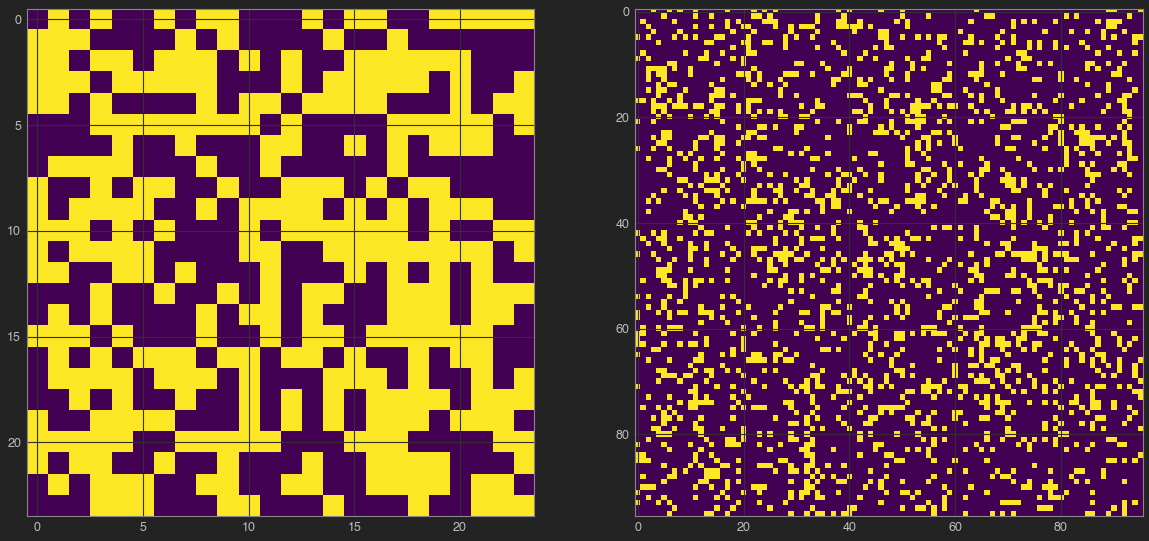

In [392]:
with open('t20.txt') as f:
    target = f.read().strip()
target = np.array([[1 if c == '#' else 0 for c in line] for line in target.split('\n')])


fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(target)
ax[1].imshow(np.fliplr(np.rot90(chart, k=2)))

In [393]:
MONSTER = """                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """

In [394]:
# print("\n".join(["".join(['#' if v==1 else '.' for v in row]) 
#     for row in np.rot90(chart,k=1)]))

In [395]:
from scipy.signal import convolve2d

In [396]:
def find_monster(chart):
    monster = np.array([[1 if c == '#' else 0 for c in line] for line in MONSTER.split('\n')])
    monster_size = monster.sum()
    monsters = [np.rot90(monster, k=k) for k in range(4)]
    monsters += [np.fliplr(m) for m in monsters]
    roughness = sum( (convolve2d(chart, monster) == monster_size).sum() for monster in monsters)
    return chart.sum() - roughness * monster_size

In [400]:
find_monster(chart)

1639

In [401]:
find_monster(assemble(parse(data)))

1639